# **ECG Classification** 
* Class 1: ARR (95 recordings)
* Class 2: CHF (30 recordings)
* Class 3: NSR(37 recordings)

***Preprocessing:*** (done in MATLAB)
* Wavelet Domain Optimized Savitzky–Golay (WOSG) filter
Reference: https://ieeexplore.ieee.org/document/9272776
 * SNR= 4.13dB

***Classifiers used:***
1. Decision tree with Gini index
2. Decision tree with Entropy
3. RF
4. Extremely randomized trees classifier (Extra trees classifier)-ERT
5. XGBoost
6. LGBM
7. Deep decision tree
8. Deep Forest



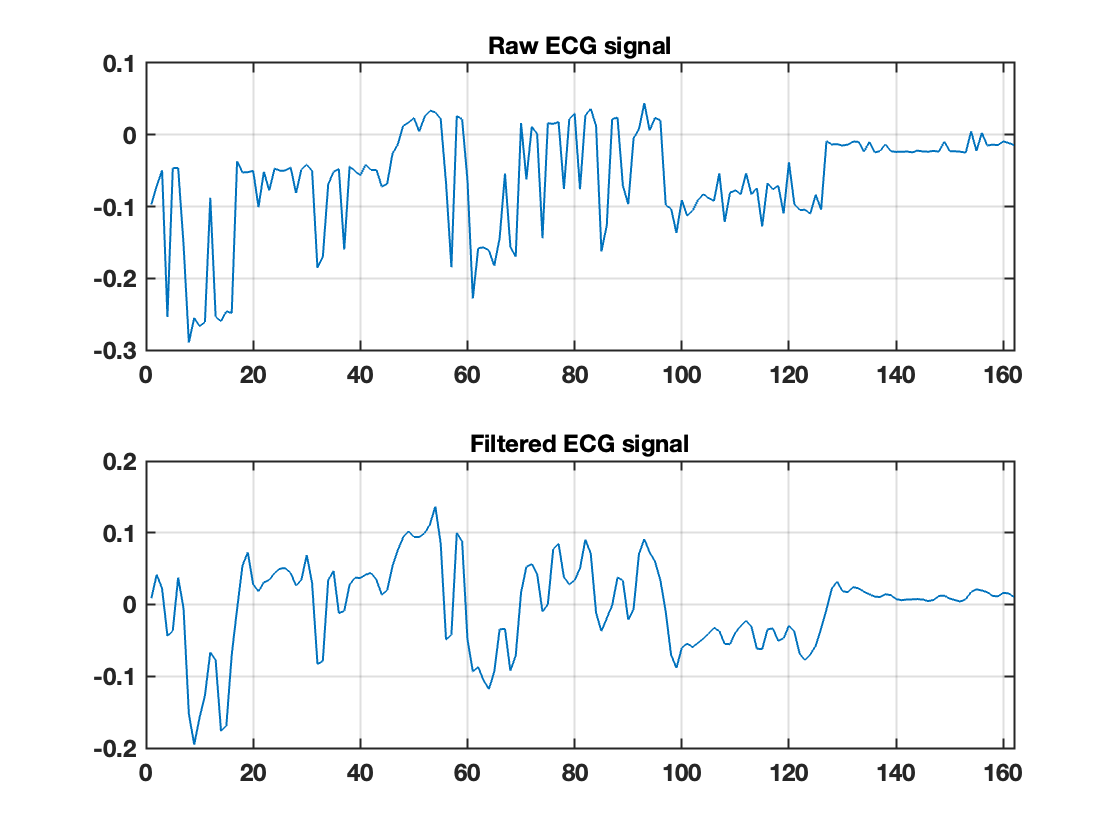

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.io import loadmat
import PIL
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [68]:
#load the ECG data from Physionet database
#https://github.com/mathworks/physionet_ECG_data/
data = loadmat("/content/drive/MyDrive/ECG_data/ECG_filtered_data.mat")
dataloaded = np.asarray(data['data'])

In [69]:
dataloaded.shape

(162, 2)

In [70]:
X=dataloaded[:,0:dataloaded.shape[1]-1]
#print(X)
X.shape

(162, 1)

In [71]:
y=dataloaded[:,dataloaded.shape[1]-1]
print(y)
y.shape

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


(162,)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
#feature scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
print(X_train.shape), print(X_test.shape)
print(y_train.shape), print(y_test.shape)

(129, 1)
(33, 1)
(129,)
(33,)


(None, None)

In [75]:
#class imbalance problem
from imblearn.over_sampling import SMOTE
smote= SMOTE(sampling_strategy='minority')
X_sm,y_sm= smote.fit_resample(X_train,y_train)
print(X_sm.shape, y_sm.shape)

(183, 1) (183,)


# **LGBM Classifier**

In [76]:
import lightgbm as lgb
model_lgbm = lgb.LGBMClassifier(learning_rate=0.15,max_depth=-5,random_state=42)
model_lgbm.fit(X_sm,y_sm,eval_set=[(X_test,y_test),(X_sm,y_sm)],
          verbose=20,eval_metric='logloss')
y_pred = model_lgbm.predict(X_test)
print(confusion_matrix(y_test,y_pred))

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

[20]	training's multi_logloss: 0.412959	training's multi_logloss: 0.412959	valid_0's multi_logloss: 0.529147	valid_0's multi_logloss: 0.529147
[40]	training's multi_logloss: 0.367853	training's multi_logloss: 0.367853	valid_0's multi_logloss: 0.503339	valid_0's multi_logloss: 0.503339
[60]	training's multi_logloss: 0.346209	training's multi_logloss: 0.346209	valid_0's multi_logloss: 0.506438	valid_0's multi_logloss: 0.506438
[80]	training's multi_logloss: 0.334438	training's multi_logloss: 0.334438	valid_0's multi_logloss: 0.514698	valid_0's multi_logloss: 0.514698
[100]	training's multi_logloss: 0.32638	training's multi_logloss: 0.32638	valid_0's multi_logloss: 0.524877	valid_0's multi_logloss: 0.524877
[[14  2  2]
 [ 4  3  0]
 [ 0  0  8]]
75.75757575757575
              precision    recall  f1-score    support
1.0            0.777778  0.777778  0.777778  18.000000
2.0            0.600000  0.428571  0.500000   7.000000
3.0            0.800000  1.000000  0.888889   8.000000
accuracy   

In [77]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 77.77777777777779
Class-2 accuracy= 42.857142857142854
Class-3 accuracy= 100.0
OA= 73.54497354497354


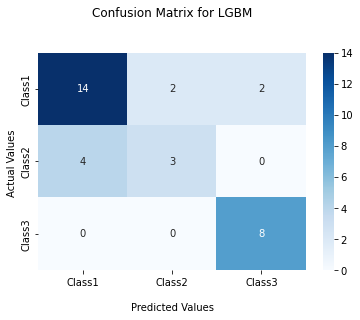

In [78]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for LGBM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Class1','Class2', 'Class3'])
ax.yaxis.set_ticklabels(['Class1','Class2', 'Class3'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **Random Forest Classifier**

In [79]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Fitting Random Forest Classification to the Training set
model_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
model_rf.fit(X_sm, y_sm)

y_pred = model_rf.predict(X_test)

cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)
cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

confusion matrix 
 [[13  4  1]
 [ 3  4  0]
 [ 2  0  6]]
69.6969696969697
              precision    recall  f1-score   support
1.0            0.722222  0.722222  0.722222  18.00000
2.0            0.500000  0.571429  0.533333   7.00000
3.0            0.857143  0.750000  0.800000   8.00000
accuracy       0.696970  0.696970  0.696970   0.69697
macro avg      0.693122  0.681217  0.685185  33.00000
weighted avg   0.707792  0.696970  0.701010  33.00000
Specificity= 82.32478632478632
Kappa= 0.4946401225114855


In [80]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 72.22222222222221
Class-2 accuracy= 57.14285714285714
Class-3 accuracy= 75.0
OA= 68.12169312169311


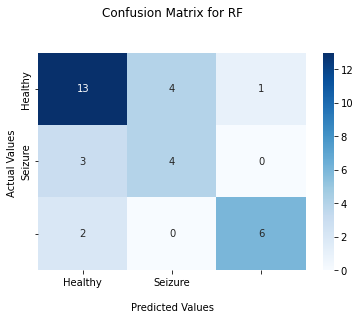

In [81]:
import seaborn as sns

ax = sns.heatmap(cm1, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for RF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Healthy','Seizure'])
ax.yaxis.set_ticklabels(['Healthy','Seizure'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **XGBoost Classifier**

In [82]:
import xgboost as xgb
from xgboost import XGBClassifier

model_xgb = XGBClassifier() 

model_xgb.fit(X_sm, y_sm)

y_pred = model_xgb.predict(X_test)

cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

confusion matrix 
 [[14  3  1]
 [ 3  4  0]
 [ 0  0  8]]
78.78787878787878
              precision    recall  f1-score    support
1.0            0.823529  0.777778  0.800000  18.000000
2.0            0.571429  0.571429  0.571429   7.000000
3.0            0.888889  1.000000  0.941176   8.000000
accuracy       0.787879  0.787879  0.787879   0.787879
macro avg      0.761282  0.783069  0.770868  33.000000
weighted avg   0.785898  0.787879  0.785740  33.000000
Specificity= 87.82051282051282
Kappa= 0.6510574018126889


In [83]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 77.77777777777779
Class-2 accuracy= 57.14285714285714
Class-3 accuracy= 100.0
OA= 78.30687830687832


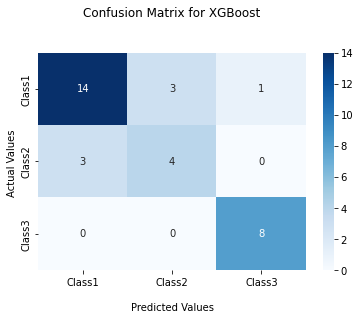

In [84]:
import seaborn as sns

ax = sns.heatmap(cm1, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for XGBoost\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Class1','Class2', 'Class3'])
ax.yaxis.set_ticklabels(['Class1','Class2', 'Class3'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **KNN Classifier**

In [85]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_sm, y_sm)
knn.score(X_test, y_test)

y_pred = knn.predict(X_test)

acc=accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

confusion matrix 
 [[13  2  3]
 [ 2  5  0]
 [ 0  0  8]]
78.78787878787878
              precision    recall  f1-score    support
1.0            0.866667  0.722222  0.787879  18.000000
2.0            0.714286  0.714286  0.714286   7.000000
3.0            0.727273  1.000000  0.842105   8.000000
accuracy       0.787879  0.787879  0.787879   0.787879
macro avg      0.769408  0.812169  0.781423  33.000000
weighted avg   0.800551  0.787879  0.785414  33.000000
Specificity= 88.17663817663818
Kappa= 0.6612903225806452


In [86]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 72.22222222222221
Class-2 accuracy= 71.42857142857143
Class-3 accuracy= 100.0
OA= 81.21693121693121


# **Decision Tree Classifier**

In [87]:
from sklearn.tree import DecisionTreeClassifier

***perform training with giniIndex.***

In [88]:
#perform training with giniIndex.
clf_gini = DecisionTreeClassifier(criterion = "gini",
          random_state = 100,max_depth=6, min_samples_leaf=6)
  
# Performing training
clf_gini.fit(X_sm, y_sm)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, random_state=100)

In [89]:
y_pred = clf_gini.predict(X_test)
print(y_pred)

[2. 3. 3. 1. 3. 1. 2. 3. 1. 1. 3. 1. 1. 3. 1. 1. 1. 1. 3. 1. 1. 2. 1. 1.
 1. 1. 3. 1. 2. 2. 3. 1. 1.]


In [90]:
print("Results using Gini Index")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Gini Index
confusion matrix 
 [[15  2  1]
 [ 4  3  0]
 [ 0  0  8]]
78.78787878787878
              precision    recall  f1-score    support
1.0            0.789474  0.833333  0.810811  18.000000
2.0            0.600000  0.428571  0.500000   7.000000
3.0            0.888889  1.000000  0.941176   8.000000
accuracy       0.787879  0.787879  0.787879   0.787879
macro avg      0.759454  0.753968  0.750662  33.000000
weighted avg   0.773383  0.787879  0.776485  33.000000
Specificity= 88.09523809523809
Kappa= 0.6390625000000001


In [91]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 83.33333333333334
Class-2 accuracy= 42.857142857142854
Class-3 accuracy= 100.0
OA= 75.3968253968254


***perform training with Entropy.***

In [92]:
#perform training with entropy.
clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 6, min_samples_leaf = 6)

# Performing training
clf_entropy.fit(X_sm, y_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=6,
                       random_state=100)

In [93]:
y_pred = clf_entropy.predict(X_test)
print(y_pred)

[2. 3. 3. 1. 3. 1. 2. 3. 1. 1. 3. 1. 1. 3. 2. 1. 1. 1. 3. 1. 1. 2. 1. 1.
 1. 1. 3. 1. 2. 2. 3. 1. 1.]


In [94]:
print("Results using Entropy")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Entropy
confusion matrix 
 [[15  2  1]
 [ 3  4  0]
 [ 0  0  8]]
81.81818181818183
              precision    recall  f1-score    support
1.0            0.833333  0.833333  0.833333  18.000000
2.0            0.666667  0.571429  0.615385   7.000000
3.0            0.888889  1.000000  0.941176   8.000000
accuracy       0.818182  0.818182  0.818182   0.818182
macro avg      0.796296  0.801587  0.796631  33.000000
weighted avg   0.811448  0.818182  0.813246  33.000000
Specificity= 89.62962962962963
Kappa= 0.695852534562212


In [95]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 83.33333333333334
Class-2 accuracy= 57.14285714285714
Class-3 accuracy= 100.0
OA= 80.15873015873017


# **Extremely Randomized Trees Classifier(Extra Trees Classifier):**


*   ***Extremely Randomized Trees Classifier(Extra Trees Classifier) is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it’s classification result. In concept, it is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest.***




In [96]:
from sklearn.ensemble import ExtraTreesClassifier

In [97]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators=25, criterion='gini', max_features='auto', bootstrap=False)
  
# Training the model
extra_tree_forest.fit(X_sm, y_sm)

ExtraTreesClassifier(n_estimators=25)

In [98]:
y_pred = extra_tree_forest.predict(X_test)
print(y_pred)

[2. 1. 3. 1. 3. 2. 2. 3. 2. 1. 3. 1. 1. 3. 2. 1. 1. 1. 3. 1. 1. 2. 1. 1.
 1. 2. 1. 1. 2. 2. 3. 1. 1.]


In [99]:
print("Results using Extremely Randomized Trees Classifier(Extra Trees Classifier)")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Extremely Randomized Trees Classifier(Extra Trees Classifier)
confusion matrix 
 [[12  5  1]
 [ 3  4  0]
 [ 2  0  6]]
66.66666666666666
              precision    recall  f1-score    support
1.0            0.705882  0.666667  0.685714  18.000000
2.0            0.444444  0.571429  0.500000   7.000000
3.0            0.857143  0.750000  0.800000   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.669157  0.662698  0.661905  33.000000
weighted avg   0.687095  0.666667  0.674026  33.000000
Specificity= 80.76923076923077
Kappa= 0.45331325301204817


In [100]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 66.66666666666666
Class-2 accuracy= 57.14285714285714
Class-3 accuracy= 75.0
OA= 66.26984126984127


# **AdaBoost Classifier**

In [101]:
from sklearn.ensemble import AdaBoostClassifier



*   Using Different Base Learners
I have used RF as a base estimator. You can use any ML learner as base estimator if it accepts sample weight such as Decision Tree, Support Vector Classifier.



In [102]:
# Import Support Vector Classifier
#from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
#from sklearn import metrics
#svc=SVC(probability=True, kernel='linear')

rf = RandomForestClassifier(n_estimators = 40, criterion = 'entropy', random_state = 42)
# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=rf,learning_rate=1)

# Train Adaboost Classifer
model_abc = abc.fit(X_sm, y_sm)

#Predict the response for test dataset
y_pred = model_abc.predict(X_test)

In [103]:
print("Results using AdaBoost Classifier with different base learners")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using AdaBoost Classifier with different base learners
confusion matrix 
 [[13  4  1]
 [ 3  4  0]
 [ 2  0  6]]
69.6969696969697
              precision    recall  f1-score   support
1.0            0.722222  0.722222  0.722222  18.00000
2.0            0.500000  0.571429  0.533333   7.00000
3.0            0.857143  0.750000  0.800000   8.00000
accuracy       0.696970  0.696970  0.696970   0.69697
macro avg      0.693122  0.681217  0.685185  33.00000
weighted avg   0.707792  0.696970  0.701010  33.00000
Specificity= 82.32478632478632
Kappa= 0.4946401225114855


In [104]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 72.22222222222221
Class-2 accuracy= 57.14285714285714
Class-3 accuracy= 75.0
OA= 68.12169312169311


# DEEP FOREST CLASSIFIER
https://github.com/LAMDA-NJU/Deep-Forest

In [105]:
pip install deep-forest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
from deepforest import CascadeForestClassifier

In [107]:
model = CascadeForestClassifier(random_state=1)
model.fit(X_sm, y_sm)
y_pred = model.predict(X_test)

[2023-02-06 20:35:06.442] Start to fit the model:
[2023-02-06 20:35:06.442] Fitting cascade layer = 0 
[2023-02-06 20:35:06.959] layer = 0  | Val Acc = 78.689 % | Elapsed = 0.517 s
[2023-02-06 20:35:06.962] Fitting cascade layer = 1 
[2023-02-06 20:35:07.492] layer = 1  | Val Acc = 81.967 % | Elapsed = 0.530 s
[2023-02-06 20:35:07.495] Fitting cascade layer = 2 
[2023-02-06 20:35:08.229] layer = 2  | Val Acc = 81.967 % | Elapsed = 0.733 s
[2023-02-06 20:35:08.229] Early stopping counter: 1 out of 2
[2023-02-06 20:35:08.232] Fitting cascade layer = 3 
[2023-02-06 20:35:08.757] layer = 3  | Val Acc = 82.514 % | Elapsed = 0.524 s
[2023-02-06 20:35:08.759] Fitting cascade layer = 4 
[2023-02-06 20:35:09.300] layer = 4  | Val Acc = 79.781 % | Elapsed = 0.541 s
[2023-02-06 20:35:09.300] Early stopping counter: 1 out of 2
[2023-02-06 20:35:09.303] Fitting cascade layer = 5 
[2023-02-06 20:35:09.851] layer = 5  | Val Acc = 80.328 % | Elapsed = 0.548 s
[2023-02-06 20:35:09.851] Early stopping c

In [108]:
print("Results using Deep forest classifier")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

#evaluate specificity
TNA=cm.iloc[1,1]+cm.iloc[1,2]+cm.iloc[2,1]+cm.iloc[2,2]
TNB=cm.iloc[0,0]+cm.iloc[0,2]+cm.iloc[2,0]+cm.iloc[2,2]
TNC=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]

FPA=cm.iloc[0,1]+cm.iloc[0,2]
FPB=cm.iloc[1,0]+cm.iloc[1,2]
FPC=cm.iloc[2,0]+cm.iloc[2,1]

specA=(TNA/(TNA+FPA))*100
specB=(TNB/(TNB+FPB))*100
specC=(TNC/(TNC+FPC))*100

Specificity=(specA+specB+specC)/3
print('Specificity=',Specificity)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Deep forest classifier
confusion matrix 
 [[12  5  1]
 [ 2  5  0]
 [ 3  0  5]]
66.66666666666666
              precision    recall  f1-score    support
1.0            0.705882  0.666667  0.685714  18.000000
2.0            0.500000  0.714286  0.588235   7.000000
3.0            0.833333  0.625000  0.714286   8.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.679739  0.668651  0.662745  33.000000
weighted avg   0.693108  0.666667  0.671963  33.000000
Specificity= 80.8977455716586
Kappa= 0.4541353383458646


In [109]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('OA=',oa)

Class-1 accuracy= 66.66666666666666
Class-2 accuracy= 71.42857142857143
Class-3 accuracy= 62.5
OA= 66.86507936507935
